# Prosjekt 2 VitBer
Gruppe 49: Martin Johnsrud, Hans Giil, Eirik Høydalsvik

In [1]:
%%javascript
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

### Teori
(Her er alltid $j$ indeks for $x$, mens $k$ er ineks for energier)

Vi skal lage en algoritme som tar i et potensialet $V(x)$, hvor vi antatr $V(x) = \infty, x \in [-\infty, 0> \cup <L, \infty]$, mens det kan ha en virkårlig form i intervallet $I = [0, L>$. $I$ Diskretiseres opp i $n$ delintervaller, $\{I_j\}_{j = 1} ^ {n}$, med lengder på $\Delta x = L / (n + 1)$. Vi diskretiserer derreter potensialet ved å sette $V_j = V(\Delta x \cdot j), \, j = 1, 2, ... n$ og grensebetingelsene $V_0 = V_{n+1} = \infty$, slik at vi har en vektor ${\vec V} = [V_1, V_2, ... V_{n + 1}]$. Den tidsuavhengige Shrödingerligningen i 1D, TUSL, er gitt ved 

$$ \hat H \psi(x) =  \Big( \frac{-\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + \hat V\Big) \psi(x) = E \psi(x) $$

Vi diskretiserer $\psi(x)$ på samme måten, og lar $\psi_j = \psi(\Delta x \cdot j),\, \psi_0 = \psi_{n+1} = 0$ som gir vektoren $\vec \psi$. Hamiltonoperatoren tilnærmes med matrisen $\mathbb{H} = [H_{j, k}]$, som er tri-diagonal, slik at

$$
\mathbb{H}=
\begin{pmatrix}
    H_{1, 1} & H_{1, 2} & 0        & 0          & \dots      & 0            \\[1mm]
    H_{2, 1} & H_{2, 2} & H_{2, 3} & 0          & \dots      & \vdots       \\[1mm]
    0        & H_{3, 2} & \ddots   & \ddots     & 0          & 0            \\[1mm]
    0        & 0        & \ddots   & \ddots     & H_{n-1, n} & 0            \\[1mm]
    \vdots   & \vdots   & 0        & H_{n, n-1} & H_{n, n}   & H_{n, n+1}   \\[1mm]
    0        & \dots    & 0        & 0          & H_{n+1, n} & H_{n+1, n+1} \\[1mm]
 \end{pmatrix}
$$

hvor $H_{j, j} = \frac{\hbar^2}{m(\Delta x)^2} + V_j$, og $H_{j, j\pm 1} = \frac{-\hbar^2}{2m(\Delta x)^2}$. TUSL kan da aproskimeres som et egenverdiproblem,

$$ \mathbb{H} \vec \psi_k = E_k \vec \psi_k$$

Dette gir $n$ forskjellige egenverdier $E_j$, med tilhørende egenvektorer $\vec \psi_k = \psi_{j, k}$, hvor den  som er en aproksimasjon av egenfunksjonen til den . Derreter kan vi tidsutvikle en vilkårilg starttilstand $\Psi (x, 0)$. Denne starttilstanden aproksimeres som en superposisjonen av egenvektorene, 

$$\Psi_j = \sum_{k = 1}^{n} c_{k} \psi_{j, k} \exp(-i E_k t / \hbar),$$

eller med matrisenotasjon $\psi = [\psi_{j, k}], \, \vec c = [c_1, c_2, ... c_{n+1}]$ blir det $\vec \Psi(t) = \psi (\vec c \cdot \exp(i t / \hbar \vec E)) $. $\vec c$ finnes ved $c_j = \sum_{j = 1}^{n + 1} \psi_{j, k} \Psi_j$, eller $\vec c = \vec \Psi^T \psi$ 

### Dimesjonsløshet

Sånn Shcrödingerlingingen står nå, vår man veldig små tall i bergeningene. Dette kan føre til flyttallfeil. Vi innfører derfor de dimesjonsløse størrelsene $ q = x / \omega $, $ \epsilon = E / (\hbar^2 / 2m\omega^2) $ og $ \hat \nu = \hat V / (\hbar^2 / 2m\omega^2) $, hvor $\omega$ er den karikteristiske størrelsen bredden til brønnen. Hele modellen får dermed en lengde $L^* = L / \omega$. Siden

$$ \frac{\partial^2}{\partial q^2} \psi(q) = \Big( \frac{\partial x}{\partial q} \frac{\partial}{\partial x} \Big)^2 \psi(x)= \omega^2 \frac{\partial^2}{\partial x^2} \psi(x), $$

kan vi ved å multiplisere med $2m\omega^2 / \hbar^2 $ på begge sider av Schrödingerligningen skrive den om til

\begin{equation}
    \label{TUSL}
    \Big(\hat \nu - \frac{\partial^2}{\partial q^2} \Big) \psi = \epsilon \psi
\end{equation}

Dette gjør at de nye elementene i $ \mathbb{H} $ matrisen blir $ H_{j, j} = 2 / (\Delta q)^2 + \hat \nu$ og $ H_{j, j \pm 1} = - 1 / (\Delta q)^2$, hvor $\Delta q = L^* / (n + 1)$.

**Notasjon**

$L^* =$ `LStar`  
$\Delta q$ = `deltaq`  
$n$ = `n`   
$\nu(q) =$ `vKont(q)`  
$\vec \nu$ = `v`  
$\epsilon_k =$ `eps[k]`  
$\psi = $ `psi[j][k]`    
$\vec \psi_k =$ `psi[:, k]`  
$\Psi(x, 0) = $ `f(x)`  
$\vec \Psi(t) = $ `Psi[j](t)`  
$\mathbb{H} = $ `H[j][k]`  

Løser (1) numerisk, som beskrevet i teorien. Returnerer $\epsilon$ og $\psi$.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import numpy as np
from numpy import pi

def solveTUSL(v, LStar):
    
    # Hjj are diagonal values, HOD are of the diagonal
    deltaq = LStar / (len(v) + 1)
    Hjj = 2 / deltaq**2 * np.ones(len(v)) + v
    HOD = -1 / deltaq**2 * np.ones(len(v) - 1)
    return la.eigh_tridiagonal(Hjj, HOD)

Lager en krystall med `Nw` brønner med dybde `v0` (anntas negativ). returnerer $\epsilon,\, \psi,\, \nu,\, n$  og $L$. `L` blir beregnet slik at brønnene får bredde `wL` meter.

In [3]:
def makeChrystal(Nw, v0):
    n = 1000 # Oppløsning
    # Størrelsene her er kun riktige i forhold til hverandre, enhetene stemmer
    # ikke overens med noe utenfor denne funksjonen
    w = 10   # Bredde mellom brønner som anndel av Length
    b = 3    # Avstand mellom brønner
    B = 10   # Bredde på sidene, i forhold til w
    Length = 2 * B * w + Nw * w  # Lengde av hele modellen
    if Nw > 1:
        Length += (Nw - 1) * b

    v = np.zeros(n * B * w // Length)
    if Nw:
        v = np.concatenate((v, v0 * np.ones(n * w // Length)))
        
    for i in range(Nw - 1):
        v = np.concatenate((v, np.zeros(n * b // Length), v0 * np.ones(n * w // Length)))
    v = np.concatenate((v, np.zeros(n * B * w // Length) // Length))

    n = len(v)   # Forsikrer at v og x har samme lengde
    LStar = Length / w
    q = np.linspace(0, LStar, n)
    eps, psi = solveTUSL(v, LStar)
    return eps, psi, v, q

Plotter potensialbrønnen, `l` energiegenverdier ($\epsilon_k$) og de tilhørende egenvektorene $\vec \psi_k$. Venstre y-akse angir verider for $\epsilon$, mens høyre gir verdier for potensialbrønnen $\nu$. 

In [4]:
def plotEigenfunc(eps, psi, v, q, l,  epsRange=(0, 0), legend=True, showWave=True):
    
    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 25}
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    mpl.rc('font', **font)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))
    
    inf = 1e10  # Alle vet at uendelig er ca 10 milliarder
    v = np.concatenate(([inf], v, [inf]))
    q = np.concatenate(([0], q, [q[-1] * (1 + 1 / len(q))]))
    
    # Inneholder Line2D elementer som viser legend hvordan linja ser ut
    legendElement = [0] * (l + 1)
    
    ax1.set_xlabel("$q$", fontsize=50)
    ax1.set_ylabel("$\epsilon $", fontsize=50)
    labels =  [0] * (l + 1)
    labels[0] = "$ \\nu (q)$"
    legendElement[0], = ax1.plot(q, v, color="Black")
    ax1.set_ylabel("$\\nu$", fontsize=50)

    scalePsi = 0
    if showWave: scalePsi = (epsRange[1] - epsRange[0]) / (5 * np.max(psi))

    for i in range(l):
        legendElement[1 + i], = ax1.plot(q[1: -1], psi[:, i] * scalePsi + eps[i] * np.ones_like(q[1: -1]))
        ax1.plot(q, eps[i] * np.ones_like(q), "--",  color= legendElement[1 + i].get_color())
        labels[1 + i] = "$\epsilon_" + str(i + 1) + "$"
    
    ax1.set_ylim(epsRange)
    ax1.set_ylim(epsRange)

    if legend:
        ax1.legend(legendElement[:][:l + 1], labels[:l + 1], fontsize=20)
    
    plt.show()

Konverterer fra den enhetsløse variablen $\epsilon$ til $E$, og gir verdier i elektronvolt eller joule.

In [5]:
def EJ(eps):
    return eps * (1.0545e-34)**2 / (9.11e-31 * 1e-10**2)

def EeV(eps):
    return eps * (1.0545e-34)**2 /  (1.6e-19 * 9.11e-31 * 1e-10**2)

## Oppgave 1: Partikkel i boks

0.024673990750591502


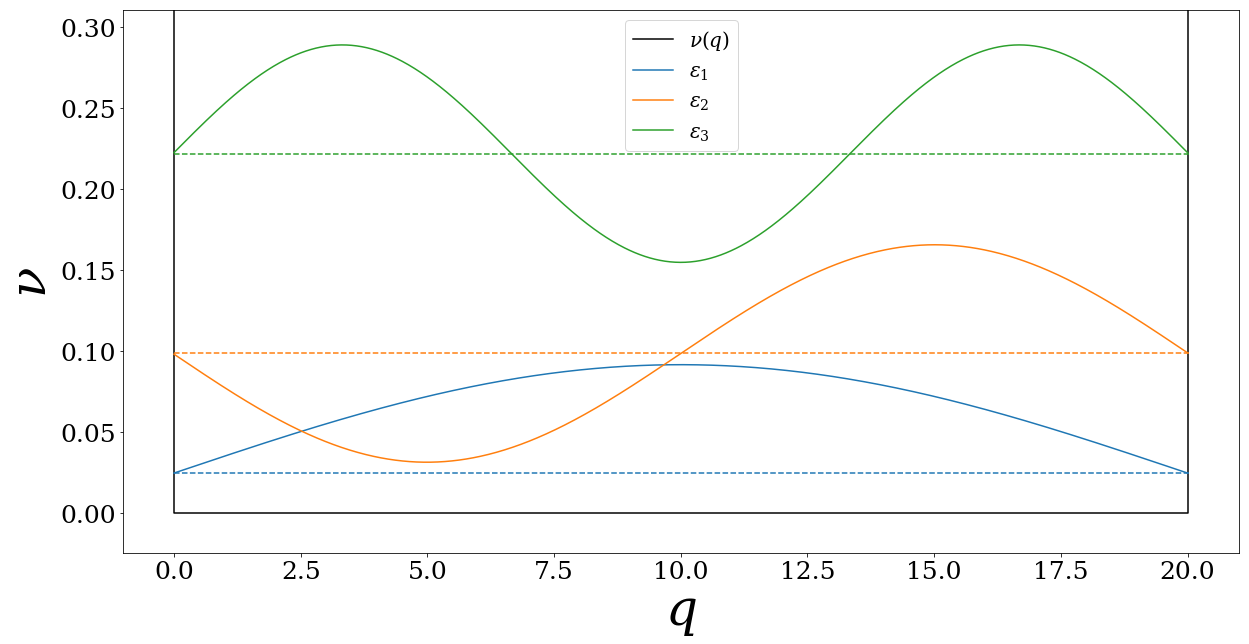

In [6]:
eps1, psi1, v1, q1 = makeChrystal(0, 0)

l1 = 3
print(eps1[0])
plotEigenfunc(eps1, psi1, v1, q1, l1, (-eps1[0], eps1[l1 - 1] * 1.4))

### Energiegenverdier

Den analytiske løsningen for energien til en partikkel i boks er 

$$ \epsilon_k = \frac{2m\omega^2}{\hbar^2} E_k = \Big(\frac{k \pi}{L^*}\Big)^2. $$

Under printes både numeriske og analytisk beregnet dimensjonsløs energi, og man kan tydlig se at de stemmer godt overens.

In [7]:
def epsExact(k, LStar):
    return (k * np.pi / LStar)**2

precision = 6
tableWidth = 15

print("Energies:")
print("Numerisk:".ljust(tableWidth), "Analytisk:".ljust(tableWidth), "Relativ feil:".ljust(tableWidth))

for i in range(l1):
    print(("{:.{prec}e}").format(eps1[i], prec=precision).ljust(tableWidth),\
          ("{:.{prec}e}").format(epsExact(i + 1, q1[-1]), prec=precision).ljust(tableWidth),\
          ("{:.{prec}e}").format((epsExact(i + 1, q1[-1]) - eps1[i]) / epsExact(i + 1, q1[-1]), prec=precision).ljust(tableWidth))

Energies:
Numerisk:       Analytisk:      Relativ feil:  
2.467399e-02    2.467401e-02    8.207880e-07   
9.869572e-02    9.869604e-02    3.283289e-06   
2.220645e-01    2.220661e-01    7.387393e-06   


### Ortonormalitet og fullstendig sett

Vi kan se her at opp til en feil av størrelsesorden $10^{-10}$ er vektorene $ \vec \psi_k $ ortonormale, altså er $\vec \psi_i \cdot \vec \psi_j = \delta_{i, j}$, eller $\psi_{j, k} \cdot \psi_{j, k}^T = \mathbb{I}$, identitetsmatrisen, som sjekkes i koden under. Dette viser også at $\psi_{j, k}$ er inverterbar, som betyr at den er en basis til $ \mathbb{R}^n $, og dermed også et fullstendig sett.

In [8]:
np.set_printoptions(precision=2)

p = psi1 @ psi1.T
print(p)

# Sjekker om diagonalen er nær 1, og resten nær 0
tol = 10e-10
i = 0
while(i < len(p[0]) and p[i, i] - 1 < tol and np.sum(abs(p[i,:i:])) < tol):
    i += 1
    
print("\nFeil innenfor toleransen: ", i == len(p))

[[ 1.00e+00 -6.70e-16 -2.29e-16 ...  1.94e-16 -1.72e-15 -2.07e-16]
 [-6.70e-16  1.00e+00  4.16e-16 ... -7.68e-17 -8.71e-17 -1.16e-16]
 [-2.29e-16  4.16e-16  1.00e+00 ... -3.99e-16  6.64e-16 -4.07e-16]
 ...
 [ 1.94e-16 -7.68e-17 -3.99e-16 ...  1.00e+00 -2.26e-15  1.81e-15]
 [-1.72e-15 -8.71e-17  6.64e-16 ... -2.26e-15  1.00e+00  4.82e-15]
 [-2.07e-16 -1.16e-16 -4.07e-16 ...  1.81e-15  4.82e-15  1.00e+00]]

Feil innenfor toleransen:  True


## Oppgave 2: Atomer

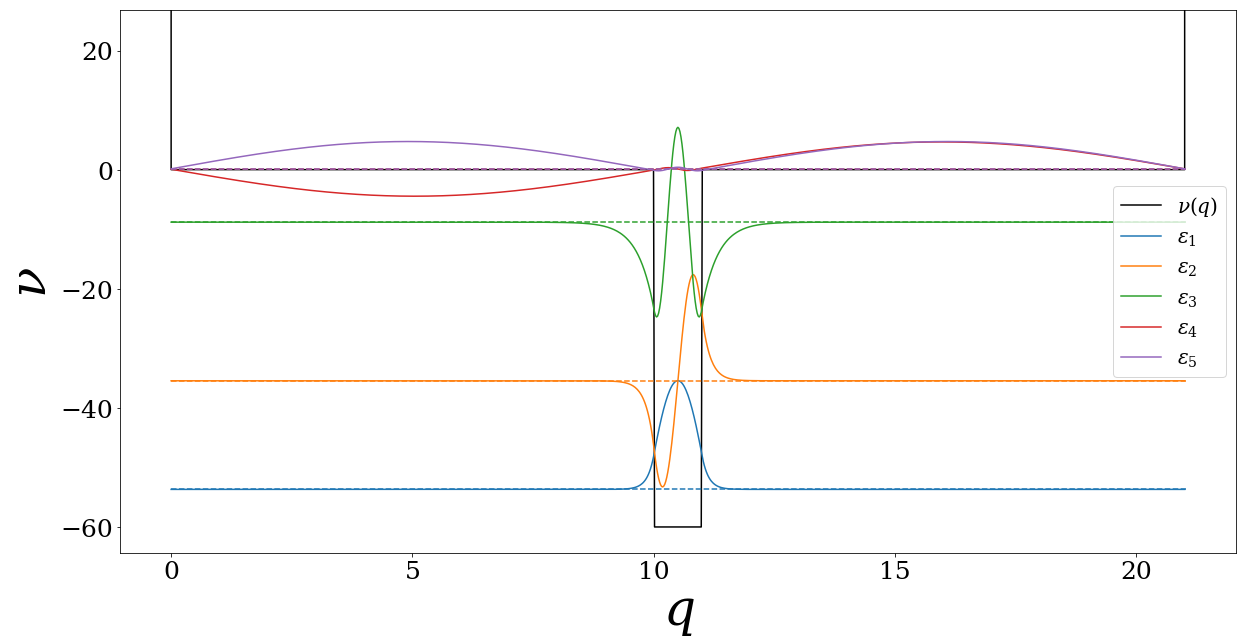

-53.69226299927868 21.0
-35.45578740110068 21.0
-8.818903007902186 21.0
0.09651733748255518 21.0
0.10171650356968996 21.0


In [18]:
v0 = -60
eps2, psi2, v2, q2 = makeChrystal(1, v0)

l2 = 5
plotEigenfunc(eps2, psi2, v2, q2, l2, (eps2[0] * 1.2, -eps2[0] * 0.5))

for i in range(l2):
    print(eps2[i], q2[-1])

## Oppgave 3: Molekyler

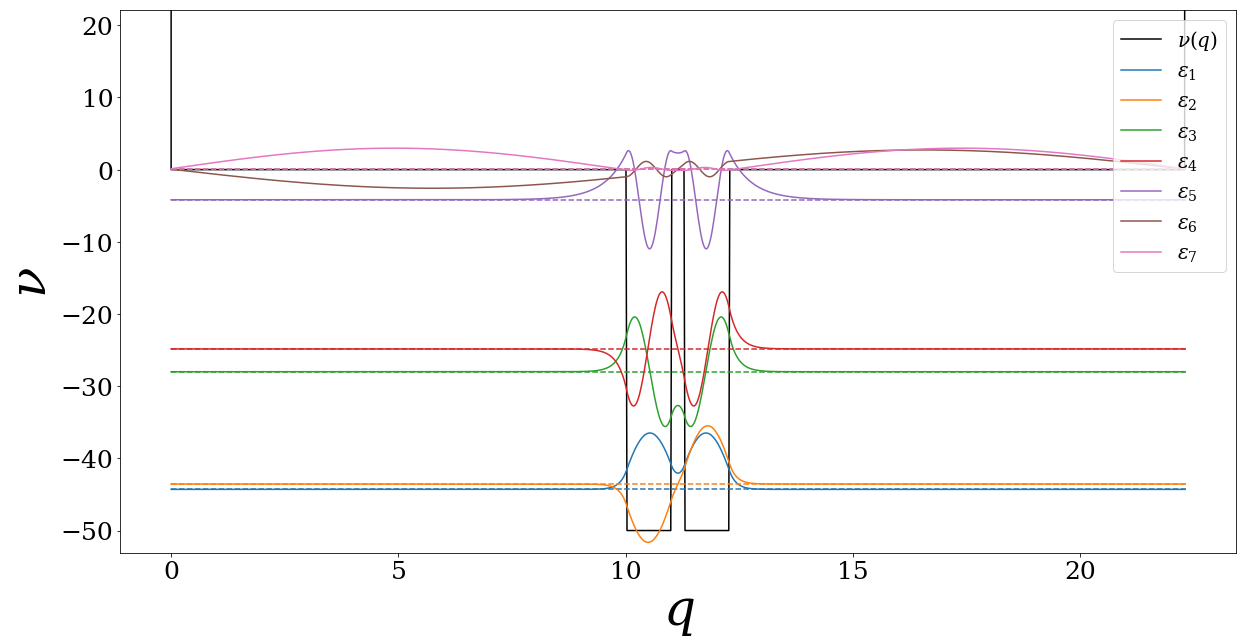

-44.301178876465336
-43.564258700503274
-27.998778477336717
-24.83761907189116
-4.173599943124766
0.07438862040930161
0.10173533261093581


In [10]:
eps3, psi3, v3, q3 = makeChrystal(2, v0)

l3 = 7
plotEigenfunc(eps3, psi3, v3, q3, l3, (eps3[0] * 1.2, -eps3[0]*0.5))

for i in range(l3):
    print(eps3[i])

## Oppgave 4: Krystaller

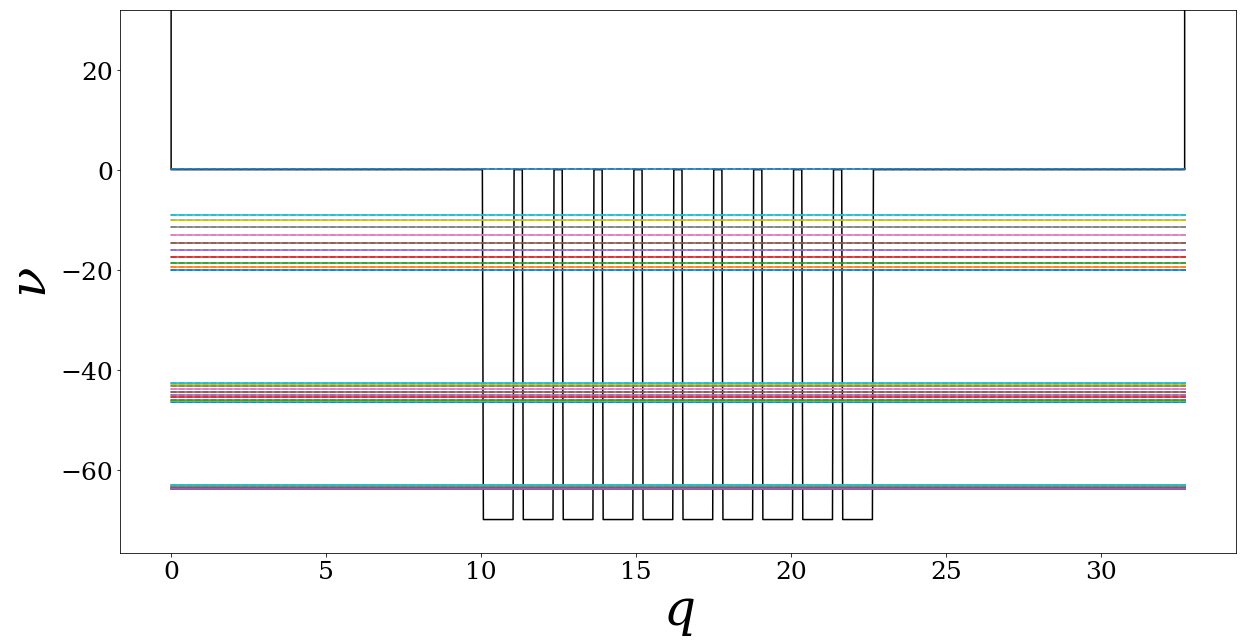

-63.966294094513444
-63.91670162221005
-63.837566608074425
-63.73413539249906
-63.61363720991727
-63.485051914523076
-63.35865930808948
-63.245301621163385
-63.15535242044541
-63.09749443820254
-46.58359591148412
-46.36522027293358
-46.01596823559935
-45.557215617459136
-45.01794183981348
-44.434405459814926
-43.849889445688675
-43.31375093742485
-42.878413502557734
-42.592932448629625
-20.083925777983588
-19.5430362176184
-18.67561544527286
-17.52785052317178
-16.15759731223666
-14.633366703209926
-13.03871049609241
-11.48347250241543
-10.120660396253356
-9.155043380763894
0.09712496958447316


In [53]:
k = 10
eps4, psi4, v4, q4 = makeChrystal(k, -70)

l4 = k * 3 + 1
plotEigenfunc(eps4, psi4, v4, q4, l4, (eps4[0] * 1.2, -eps4[0]*0.5), legend=False, showWave=False)

for i in range(l4):
    print(eps4[i])

## Bonus: Tidsutvikling

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


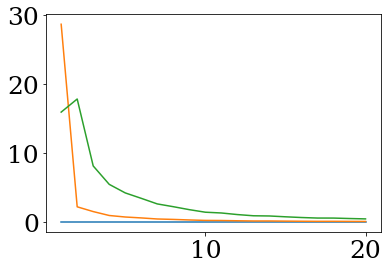

In [47]:
m = 20
x = np.arange(1, m + 1)
y = np.zeros((3, m))
print(y)
for i in x: 
    for j in range(len(y)):
        eps, a, b, c = makeChrystal(i, -70)
        y[j, i - 1] = eps[(j) * (i + 1)] - eps[j * (i)]
        
for i in range(len(y)):
    plt.plot(x, y[i], label=str(i))
plt.show()